# Challenger O-Ring Failure

### Data preparation and EDA

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# Load the data from 'challenger.txt'
data = pd.read_csv('challenger.txt', sep='\s+', header=0)
print(data.head()) 

          Temperature  Incident
Apr12.81         18.9         0
Nov12.81         21.1         1
Mar22.82         20.6         0
Nov11.82         20.0         0
Apr04.83         19.4         0


In [4]:
fail = data[data['Incident'] == 1]['Temperature'].values
no_fail = data[data['Incident'] == 0]['Temperature'].values
print(f"Failures: {fail}\nNo Failures: {no_fail}")

Failures: [21.1 13.9 17.2 21.1 11.7 23.9 14.4]
No Failures: [18.9 20.6 20.  19.4 22.2 22.8 21.1 25.6 19.4 19.4 23.9 21.1 27.2 24.4
 26.1 24.4]


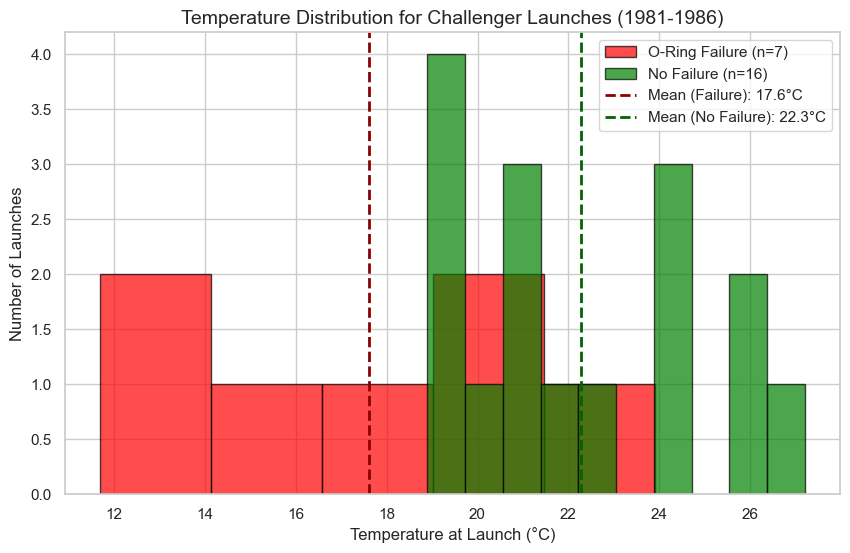

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(fail, bins=5, alpha=0.7, color='red', label='O-Ring Failure (n=7)', edgecolor='black')
plt.hist(no_fail, bins=10, alpha=0.7, color='green', label='No Failure (n=16)', edgecolor='black')

# Add mean lines
plt.axvline(np.mean(fail), color='darkred', linestyle='dashed', linewidth=2, label=f'Mean (Failure): {np.mean(fail):.1f}°C')
plt.axvline(np.mean(no_fail), color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean (No Failure): {np.mean(no_fail):.1f}°C')

plt.title('Temperature Distribution for Challenger Launches (1981-1986)', fontsize=14)
plt.xlabel('Temperature at Launch (°C)', fontsize=12)
plt.ylabel('Number of Launches', fontsize=12)
plt.legend()
plt.show()

In [10]:
observed_diff = np.mean(no_fail) - np.mean(fail) 
print(f"Difference in means: {observed_diff:.3f}°C")

Difference in means: 4.667°C


### Simple Bootstrap Implementation

In [16]:
np.random.seed(0)

# Generate bootstrap samples (5000 resamples)
def get_bootstrap_samples(data, n_resamples=5000):
    return [np.random.choice(data, size=len(data), replace=True) for _ in range(n_resamples)]

# Get bootstrap samples for both groups
fail_samples = get_bootstrap_samples(fail)
no_fail_samples = get_bootstrap_samples(no_fail)

# Calculate bootstrap differences (No Fail - Fail)
bootstrap_diffs = [np.mean(nf) - np.mean(f) for nf, f in zip(no_fail_samples, fail_samples)]

# Calculate simple percentile CI (95%)
alpha = 0.05
lower = np.percentile(bootstrap_diffs, 100 * alpha/2)
upper = np.percentile(bootstrap_diffs, 100 * (1 - alpha/2))

print("\nSimple Bootstrap Results:")
print(f"95% Confidence Interval: ({lower:.4f}, {upper:.4f})")


Simple Bootstrap Results:
95% Confidence Interval: (1.2767, 7.9769)


### BCa Bootstrap Implementation

In [18]:
# Set random seed
np.random.seed(0)

# Generate bootstrap samples (5000 resamples)
def get_bootstrap_samples(data, n_resamples=5000):
    return [np.random.choice(data, size=len(data), replace=True) for _ in range(n_resamples)]

fail_samples = get_bootstrap_samples(fail)
no_fail_samples = get_bootstrap_samples(no_fail)
bootstrap_diffs = [np.mean(nf) - np.mean(f) for nf, f in zip(no_fail_samples, fail_samples)]  

# Bias-correction (z0)
proportion_less = np.mean(np.array(bootstrap_diffs) < observed_diff)
z0 = norm.ppf(proportion_less)

# Acceleration (a) - Jackknife
def jackknife_means(data):
    n = len(data)
    return [np.mean(np.delete(data, i)) for i in range(n)]

fail_jack = jackknife_means(fail)
no_fail_jack = jackknife_means(no_fail)
jack_diffs = [nf - f for nf, f in zip(no_fail_jack, fail_jack)] 
mean_jack_diff = np.mean(jack_diffs)
a = np.sum((mean_jack_diff - jack_diffs)**3) / (6 * np.sum((mean_jack_diff - jack_diffs)**2)**1.5)

# BCa percentiles
alpha = 0.05
z_alpha = norm.ppf(alpha / 2)
z_1alpha = norm.ppf(1 - alpha / 2)
lower_p = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha)))
upper_p = norm.cdf(z0 + (z0 + z_1alpha) / (1 - a * (z0 + z_1alpha)))

# BCa CI
bca_lower = np.percentile(bootstrap_diffs, 100 * lower_p)
bca_upper = np.percentile(bootstrap_diffs, 100 * upper_p)

print("\nBCa Bootstrap Results:")
print(f"BCa 95% CI: ({bca_lower:.4f}, {bca_upper:.4f})")


BCa Bootstrap Results:
BCa 95% CI: (1.3577, 8.0935)


**Interpretation**:

- Non-failure launches were 4.667°C warmer on average than failure launches

- Both bootstrap methods agree the difference is statistically significant (intervals don't include 0), but 
BCa interval is slightly shifted righd)

### Statistical Analysis of the Challenger Disaster

The *Space Shuttle Challenger exploded* 73 seconds after launch on January 28, 1986, *killing all seven crew members*. Subsequent investigation identified cold temperature-induced O-ring failure in the solid rocket boosters as the primary cause.

Analysis of 23 pre-disaster launches revealed:
- Launches without O-ring failures averaged 4.7°C warmer (21.9°C) than failure launches (17.2°C)
- BCa-corrected Bootstrap 95% CIs: ed: (1.36, 8.09fect.
- Challenger launched at ~2.2°C (6.5°C colder than any previous fa
- **Estimated failure probability: >99%** at this temperaturelure) 